# Curve fitting for downstream task scores

16 September 2024

This notebook maps task bpb loss (actual, not predicted) to task scores. The fitting function is taken to be a reverse sigmoid function (low bpb loss on the left indicates higher task score). This is inspired from the llama3.1 paper, and can be intuitively explained as follows: 
* As the model starts to learn, the initial high bpb loss values correspond to random performance (accuracy = 0.25).
* As the model improves, the loss decreases and the scores increase.
* At some point, the model reaches saturation on the task, and any loss values within a small enough range correspond to highest possible score for that task (accuracy = 1.0).


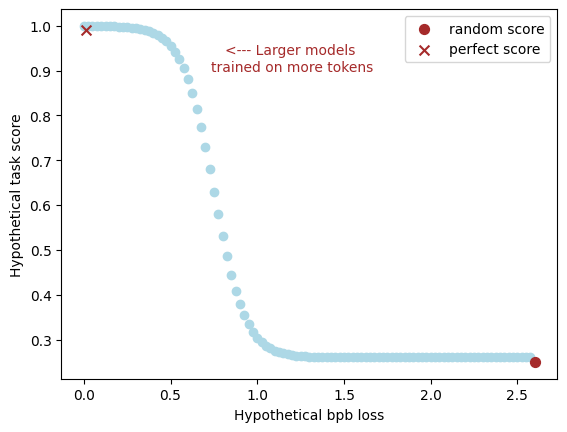

In [1]:
from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x, L, x0, k, b):
    o = L / (1 + np.exp(- k * (x - x0))) + b
    return (o)

plt.figure()
x = np.arange(0, 2.6, 0.025)
y = [sigmoid(x_, -0.74, 0.75, 11, 1) for x_ in x]
plt.scatter(x, y, color="lightblue")
plt.scatter(2.6, 0.25, label="random score", color="brown", s=50)
plt.scatter(0.01, 0.99, label="perfect score", color="brown", marker="x", s=50)

plt.annotate(
    "<--- Larger models \ntrained on more tokens",
    (1.2, 0.9),
    textcoords="offset points",
    xytext=(0, 0),
    ha="center",
    fontsize=10,
    color="brown",
)

plt.xlabel("Hypothetical bpb loss")
plt.ylabel("Hypothetical task score")
plt.legend(loc="upper right", ncols=1)
plt.show()

**Trick 1: We add 2 extra points based on the following assumptions as a sanity check:**
* For every task, the lowest possible bpb loss = 0.01, which corresponds to task score = 1.0 (perfect score).
* For every task, the highest possible bpb loss = 2.6, which corresponds to a task score = 0.25 (random score). This bpb value is somewhat arbitrarily chosen after eyeballing the bpb values of all the tasks.
* This also helps avoid the rare cases when the fitting function degenerates for very noisy data.
* We can be a bit smarter about picking different "ideal" values for each task, based on task knowledge, but the above assumptions seem good enough for the most part.

**Trick 2: Use the moving average of bpb loss to map to the task score, instead of raw bpb scores.**
* I have picked window size = 20 (the smallest model has only 20 eval points, so a larger window size will lead to loss of points for that model).
* We can pick a different window size per task (I tried out a few random values, and it did improve the relative error a little bit), but it is not clear what is the "ideal" window size.

**Trick 3: Use exponential moving average of bpb loss to map to the task score, instead of raw bpb scores.**
* I have picked alpha = 0.5.
* Tried with alpha = 0.7, 0.9 as well. Different tasks exhibit different results.

**Trick 4: Instead of all the bpb to score pairs, only use the last n% points per run.**
* I have chosen 2%.

### Other notes
* For aggregate findings below, I have removed boolq due to extremely noisy error rates.

## Findings

* MMLU var score predictions are good (0.0% on easier setting, 0.5% on hard setting).
* BoolQ bpb to score mapping is extremely noisy and unusable. I have removed it from the tables below.
* For *most* tasks, using a simple moving average improves prediction. (This will require that bpb score prediction also predicts moving average).

### Predictions for 3B-5xC, using upto 3B-2xC (easy setting)
* We use every run except the final one.

| Task | rel error (raw) | rel error (w = 20) | rel error (alpha = 0.5) | rel error (last 2%) |
| --- | --- | --- | --- | --- |
| HellaSwag-0shot | -0.7% | -0.3% | -0.5% | -0.5% |
| MMLU-Var | -2.0% | +0.0% | -0.9% | -1.6% |
| HellaSwag-5shot | +2.6% | +3.4% | +3.1% | +2.7% |
| ARC-Easy-5shot | -6.8% | -3.9% | -6.5% | -7.1% |
| ARC-Challenge-5shot | -4.5% | +1.2% | -2.3% | -4.6% |
| PiQA-5shot | -1.2% | -2.8% | -1.1% | -1.5% |
| Winogrande-5shot | -2.9% | +1.0% | -1.4% | -4.8% |
| OpenbookQA-5shot | +3.5% | +5.1% | +4.9% | +4.1% |
| SciQ-0shot | -2.0% | -0.9% | -0.3% | -0.5% |
| Copa-0shot | -6.9% | -8.1% | -7.1% | -6.8% |
| CSQA-5shot | +0.5% | +0.9% | +0.2% | +1.3% |
| SocialIQA-5shot | -4.0% | -1.6% | -3.6% | -5.8% |
| **Average error** | **-2.0%** | **-0.5%** | **-1.3%** | **-2.1%**|


### Predictions for fully trained 1B-3T model, using upto 1B-10xC
* **Note: For this particular 1B-3T run, we only have the metrics for the final checkpoint, so cannot do moving average window predictions.**

| Task | rel error (raw) | rel error (w = 20) | rel error (alpha = 0.5) | rel error (last 2%) |
| --- | --- | --- | --- | --- |
| HellaSwag-0shot | -0.0% | NA | +0.1% | -0.2% |
| MMLU-Var | -0.5% | NA | -0.3% | -0.2% |
| HellaSwag-5shot | +0.4% | NA | +0.6% | +0.3% |
| ARC-Easy-5shot | -5.6% | NA | -5.6% | -5.3% |
| ARC-Challenge-5shot | -9.5% | NA | -9.3% | -8.9% |
| PiQA-5shot | -1.6% | NA | -1.6% | -1.7% |
| Winogrande-5shot | -3.6% | NA | -2.5% | -5.2% |
| OpenbookQA-5shot | -1.6% | NA | -1.3% | +0.8% |
| SciQ-0shot | -1.7% | NA | -0.5% | -0.7% |
| Copa-0shot | -7.2% | NA | -7.3% | -6.9% |
| CSQA-5shot | -1.7% | NA | -1.7% | -1.5% |
| SocialIQA-5shot | -5.3% | NA | -5.2% | -5.8% |
| **Average error** | **-3.2%** | **NA** | **-2.9%** | **-3.0%**|


### Predictions for 3B-5xC, using upto 1B-10xC (hard setting)

* We do not use 3B runs trained upto 2xC. This is to mimic the situation where we want to predict, say 7B or 70B task scores, and do not have the budget to do multiple runs upto 2xC for the large model.

| Task | rel error (raw) | rel error (w = 20) | rel error (alpha = 0.5) | rel error (last 2%) |
| --- | --- | --- | --- | --- |
| HellaSwag-0shot | -0.5% | -0.7% | -0.3% | -0.4% |
| MMLU-Var | -2.1% | -0.5% | -0.9% | -1.5% |
| HellaSwag-5shot | +2.8% | +2.8% | +3.2% | +2.8% |
| ARC-Easy-5shot | -7.5% | -5.1% | -7.3% | -7.4% |
| ARC-Challenge-5shot | -7.2% | -3.5% | -5.5% | -7.0% |
| PiQA-5shot | -1.4% | -3.2% | -1.3% | -1.7% |
| Winogrande-5shot | -2.1% | +1.4% | -0.3% | -4.9% |
| OpenbookQA-5shot | +3.5% | +4.1% | +4.9% | +10.7% |
| SciQ-0shot | -2.2% | -1.0% | -0.5% | -0.6% |
| Copa-0shot | -7.0% | -8.5% | -7.3% | -7.0% |
| CSQA-5shot | +1.0% | +1.0% | +0.7% | +1.6% |
| SocialIQA-5shot | -4.2% | -1.9% | -3.8% | -6.0% |
| **Average error** | **-2.2%** | **-1.3%** | **-1.5%** | **-1.8%**|

## Download W&B logs

In [2]:
from olmo.scaling.scaling_laws.download_wandb_logs import main as download_wb
from olmo.scaling.scaling_laws.utils import downstream_bpb
from argparse import Namespace
import os

/Users/akshitab/virtuals/olmo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
WANDB_RESULTS = "wandb/amberish-rulebased"
FIGURES = "figures"

In [4]:
def get_name_size_length(run_name: str):
    run_name = run_name.split("/")[-1]
    size, length = run_name.split("-")[-2:]
    return run_name, size, length

In [5]:
import itertools
run_names = [
    f"ai2-llm/olmo-ladder/amberish-rulebased-{size}-{length}" 
    for size, length in itertools.product(["150M", "300M", "530M", "750M", "1B", "3B"], ["1xC", "2xC", "5xC", "10xC"])
]

validation_outputs = {}

for run_name in run_names:

    output_name = run_name.split("/")[-1]
    name, size, length = get_name_size_length(run_name)
    output_name = f"{size}-{length}"
    output_path = f"{WANDB_RESULTS}/{output_name}.csv"
    args = Namespace(
        wandb_names=[run_name],
        x_axis="throughput/total_tokens",
        y_axis=["eval/validation-and-bpb-and-downstream"],
        output_path=output_path,
    )
    if not os.path.exists(output_path):
        download_wb(args)
    validation_outputs[output_name] = output_path

## Setup

In [6]:
import numpy as np
import pandas as pd
import ladder
from olmo.scaling.scaling_laws.utils import validation as validation_names
from olmo.scaling.scaling_laws.utils import downstream_bpb as downstream_bpb_names
from olmo.scaling.scaling_laws.utils import downstream as downstream_names

import numpy as np
import matplotlib.pyplot as plt
from olmo.scaling.scaling_laws.utils import (
    get_coefficients_huber,
    chinchilla_flops_fit,
    grad_chinchilla_flops_fit,
    chinchilla_n_d_fit,
    grad_chinchilla_n_d_fit,
    FinalConfig,
    get_final_data_by_name,
    get_data_by_name,
)

In [7]:
from typing import Optional

def get_gflops(run_name: str, length_in_tokens: Optional[int] = None):
    run_name, size, length = get_name_size_length(run_name)
    length_in_tokens = length_in_tokens or ladder.parse_length(length, ladder.parse_size(size))
    flops = ladder.MODEL_GFLOPS[size]
    return flops * length_in_tokens / 1e9

def get_params(run_name: str):
    run_name, size, length = get_name_size_length(run_name)
    params = ladder.MODEL_PARAMS[size]
    return params

In [8]:
from collections import defaultdict
import csv

def get_all_data_by_name(configs, keys):
    data_by_name = defaultdict(lambda: defaultdict(lambda: []))
    for name, config in configs.items():
        for path in config.paths:
            with open(path) as file_ref:
                reader = csv.DictReader(file_ref)
                rows = [row for row in reader]
                values = []
                for row in rows:
                    y = np.mean([float(row[key]) for key in keys])
                    data_by_name[name][path].append(y)
    return data_by_name

In [9]:
from scipy.optimize import curve_fit

def sigmoid(x, L, x0, k, b):
    o = L / (1 + np.exp(- k * (x - x0))) + b
    return (o)

def reverse_sigmoid(y, L, x0, k, b):
    return x0 - 1/k * np.log((L / (y - b)) -1)

# Error with using huber fit; possibly due to incorrect bounds (try later).

# def sigmoid_fit(x, p):
#     return p[0] / (1 + np.exp(-p[2] * (x - p[1]))) + p[3]

# def grad_sigmoid_fit(x, p):
#     grad_L = 1 / (1 + np.exp(-p[2] * (x - p[1])))
#     grad_x0 = p[0] * p[2] * sigmoid_fit(x, p) * (1 - sigmoid_fit(x, p))
#     grad_k = p[0] * (x - p[1]) * sigmoid_fit(x, p) * (1 - sigmoid_fit(x, p))
#     grad_b = 1
#     return [grad_L, grad_x0, grad_k, grad_b]

# # fit the parameters
# coefficients = get_coefficients_huber(
#     train_nds,
#     train_ys,
#     sigmoid_fit,
#     grad_sigmoid_fit,
#     p0=[-1.3, 0.5, 3, 0.3],
#     bounds=None, #[(None, 0), (None, None), (None, None), (None, None)],
# )

In [10]:
def size_length_from_path(path):
    #wandb/amberish-rulebased/150M-1xC.csv
    name = path.split("/")[-1].strip(".csv")
    return name.split("-")[:2]

def get_dataframe(x_dict, y_dict):
    df = pd.DataFrame()
    xs = []
    ys = []
    sizes = []
    lengths = []
    modes = []
    runs = []
    for name, path_dict in x_dict.items():
        config = configs[name]
        for path in path_dict:
            size, length = size_length_from_path(path)
            run_name = f"{size}-{length}"
            x_data = x_dict[name][path]
            y_data = y_dict[name][path]
            size = [size for _ in range(len(x_data))]
            length = [length for _ in range(len(x_data))]
            mode = [config.mode for _ in range(len(x_data))]
            run = [run_name for _ in range(len(x_data))]
            xs += x_data
            ys += y_data
            sizes += size
            lengths += length
            modes += mode
            runs += run
    df["x"] = xs
    df["y"] = ys
    df["size"] = sizes
    df["length"] = lengths
    df["mode"] = modes
    df["run"] = runs
    return df

In [11]:
color_map = {
    "150M": "darkred",
    "300M": "darkorange",
    "530M": "gold",
    "750M": "darkgreen",
    "1B": "teal",
    "3B": "violet",
    #"7B":
}

pd.options.mode.chained_assignment = None

def fit_and_plot(df, ax, x_label="", y_label="", title="Fitting final score", add_ideal_points=True):
    df = df.dropna()

    for label in df["size"].unique():
        adf = df[df["size"]==label]
        ax.scatter(adf["x"], adf["y"], color="white", edgecolors=adf["size"].apply(lambda x: color_map[x]), s=7.0, label=label)

    train_xs = df[df["mode"]=="train"]["x"]
    train_ys = df[df["mode"]=="train"]["y"]

    if add_ideal_points:
        train_xs = pd.concat([pd.Series([0.01]), train_xs, pd.Series([2.6])], ignore_index=True)
        train_ys = pd.concat([pd.Series([1.0]), train_ys, pd.Series([0.25])], ignore_index=True)

    coefficients, pcov = curve_fit(sigmoid, train_xs, train_ys, p0=[-1, 0.4, 3, 0.3], maxfev=1000000)
    df["predicted_y"] = df["x"].apply(lambda x: sigmoid(x, *coefficients))
    
    eval_row = df[df["mode"]=="eval"].iloc[-1]
    x = eval_row["x"]
    y = eval_row["y"]
    y_pred = eval_row["predicted_y"]
    rel_error = (y_pred - y) / y
    
    ax.scatter(x, y, marker="x", color="blue", label=f"actual = {y:0.4f}", s=50)
    ax.scatter(x, y_pred, marker="^", color="black", label=f"predicted = {y_pred:0.4}", s=50)
    ax.annotate(
        f"{eval_row['run']}: {rel_error * 100:+.1f}%",
        (x, y),
        textcoords="offset points",
        xytext=(30, 5),
        ha="center",
        fontsize=10,
        color="brown",
    )
    
    #plotted_xs = np.linspace(df["xs"].max(), reverse_sigmoid(0.93, *coefficients), 100)
    if add_ideal_points:
        plotted_xs = np.linspace(max(2.6, df["x"].max()), 0.01, 100)
    else:
        plotted_xs = np.linspace(df["x"].max(), df["x"].min(), 100)
    plotted_ys = [sigmoid(x_val, *coefficients) for x_val in plotted_xs]
    
    ax.plot(
        plotted_xs,
        plotted_ys,
        color="black",
        linestyle="--",
        linewidth=0.8,
    )

    # L, x0, k, b = coefficients
    # print(f"σ(L, x0, k, b) \n = {L:.2f} / (1 + e^(-({k:.2f}(x - {x0:.2f})))) + {b:.2f}")
    # ax.text(
    #     x=0.25,
    #     y=0.50,
    #     s=f"σ(L, x0, k, b) \n = {L:.2f} / (1 + e^(-({k:.2f}(x - {x0:.2f})))) + {b:.2f}",
    #     fontsize=10,
    #     transform=plt.gca().transAxes,
    # )
    
    ax.legend(loc="upper right", ncols=1)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    return df

In [12]:
# We only include ce loss and the 6 dolma sets, as these are the sets we can include in the paper
ce_columns = [
    'eval/c4_en-validation/CrossEntropyLoss',
    'eval/dolma_books-validation/CrossEntropyLoss',
    'eval/dolma_common-crawl-validation/CrossEntropyLoss',
    'eval/dolma_pes2o-validation/CrossEntropyLoss',
    'eval/dolma_reddit-validation/CrossEntropyLoss',
    'eval/dolma_stack-validation/CrossEntropyLoss',
    'eval/dolma_wiki-validation/CrossEntropyLoss',
]

mmlu_names = ["mmlu_stem", "mmlu_humanities", "mmlu_social_sciences", "mmlu_other"]

tasks = {
    "HellaSwag-0shot": {
        "bpb": ["eval/downstream_bpb/hellaswag_rc_0shot_bpb_bpb"],
        "score": ["eval/downstream/hellaswag_rc_0shot_len_norm"],
    },
    "MMLU-Var": {
        "bpb": [f"eval/downstream_bpb/{n}_var_bpb_bpb" for n in mmlu_names],
        "score": [f"eval/downstream/{n}_var_len_norm" for n in mmlu_names],
        "x_label": "mmlu_var_bpb",
        "y_label": "mmlu_var_score",
    },
    "HellaSwag-5shot": {
        "bpb": ["eval/downstream_bpb/hellaswag_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/hellaswag_rc_5shot_len_norm"],
    },
    "ARC-Easy-5shot": {
        "bpb": ["eval/downstream_bpb/arc_easy_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/arc_easy_rc_5shot_acc"],
    },
    "ARC-Challenge-5shot": {
        "bpb": ["eval/downstream_bpb/arc_challenge_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/arc_challenge_rc_5shot_len_norm"],
    },
    "PiQA-5shot": {
        "bpb": ["eval/downstream_bpb/piqa_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/piqa_rc_5shot_len_norm"],
    },
    "Winogrande-5shot": {
        "bpb": ["eval/downstream_bpb/winogrande_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/winogrande_rc_5shot_acc"],
    },
    "OpenbookQA-5shot": {
        "bpb": ["eval/downstream_bpb/openbookqa_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/openbookqa_rc_5shot_len_norm"],
    },
    # "BoolQ-5shot": {
    #     "bpb": ["eval/downstream_bpb/boolq_rc_5shot_bpb_bpb"],
    #     "score": ["eval/downstream/boolq_rc_5shot_acc"],
    # },
    "SciQ-0shot": {
        "bpb": ["eval/downstream_bpb/sciq_rc_0shot_bpb_bpb"],
        "score": ["eval/downstream/sciq_rc_0shot_acc"],
    },
    "Copa-0shot": {
        "bpb": ["eval/downstream_bpb/copa_rc_0shot_bpb_bpb"],
        "score": ["eval/downstream/copa_rc_0shot_acc"],
    },
    "CSQA-5shot": {
        "bpb": ["eval/downstream_bpb/csqa_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/csqa_rc_5shot_len_norm"],
    },
    "SocialIQA-5shot": {
        "bpb": ["eval/downstream_bpb/socialiqa_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/socialiqa_rc_5shot_len_norm"],
    }
}

## Using upto 3B-2xC results to predict 3B-5xC

We use every run except the final one.

In [13]:
configs = {
    "150m": {
        "paths": [
            "wandb/amberish-rulebased/150M-1xC.csv",
            "wandb/amberish-rulebased/150M-2xC.csv",
            "wandb/amberish-rulebased/150M-5xC.csv",
            "wandb/amberish-rulebased/150M-10xC.csv"
        ],
        "mode": "train",
        "n": 151898880,
        "label": "150m",
        "color": "darkred"
    },
    "300m": {
        "paths": [
            "wandb/amberish-rulebased/300M-1xC.csv",
            "wandb/amberish-rulebased/300M-2xC.csv",
            "wandb/amberish-rulebased/300M-5xC.csv",
            "wandb/amberish-rulebased/300M-10xC.csv"
        ],
        "mode": "train",
        "n": 319980544,
        "label": "300m",
        "color": "darkorange"
    },
    "530m": {
        "paths": [
            "wandb/amberish-rulebased/530M-1xC.csv",
            "wandb/amberish-rulebased/530M-2xC.csv",
            "wandb/amberish-rulebased/530M-5xC.csv",
            "wandb/amberish-rulebased/530M-10xC.csv"
        ],
        "mode": "train",
        "n": 530074944,
        "label": "530m",
        "color": "gold"
    },
    "700m": {
        "paths": [
            "wandb/amberish-rulebased/750M-1xC.csv",
            "wandb/amberish-rulebased/750M-2xC.csv",
            "wandb/amberish-rulebased/750M-5xC.csv",
            "wandb/amberish-rulebased/750M-10xC.csv"
        ],
        "mode": "train",
        "n": 681297408,
        "label": "750m",
        "color": "darkgreen"
    },
    "1b": {
        "paths": [
            "wandb/amberish-rulebased/1B-1xC.csv",
            "wandb/amberish-rulebased/1B-2xC.csv",
            "wandb/amberish-rulebased/1B-5xC.csv",
            "wandb/amberish-rulebased/1B-10xC.csv"
        ],
        "mode": "train",
        "n": 1176832000,
        "label": "1b",
        "color": "teal"
    },
    "3b": {
        "paths": [
            "wandb/amberish-rulebased/3B-1xC.csv",
            "wandb/amberish-rulebased/3B-2xC.csv",
        ],
        "mode": "train",
        "n": 3002871040,
        "label": "3b",
        "color": "violet"
    },
    "3b-final": {
        "paths": [
            "wandb/amberish-rulebased/3B-5xC.csv"
            #"wandb/amberish1-newline/1B-3T.csv"
        ],
        "mode": "eval",
        "n": 3002871040,
        "label": "3b",
        "color": "violet"
    }
}

configs = {name: FinalConfig(**config) for name, config in configs.items()}

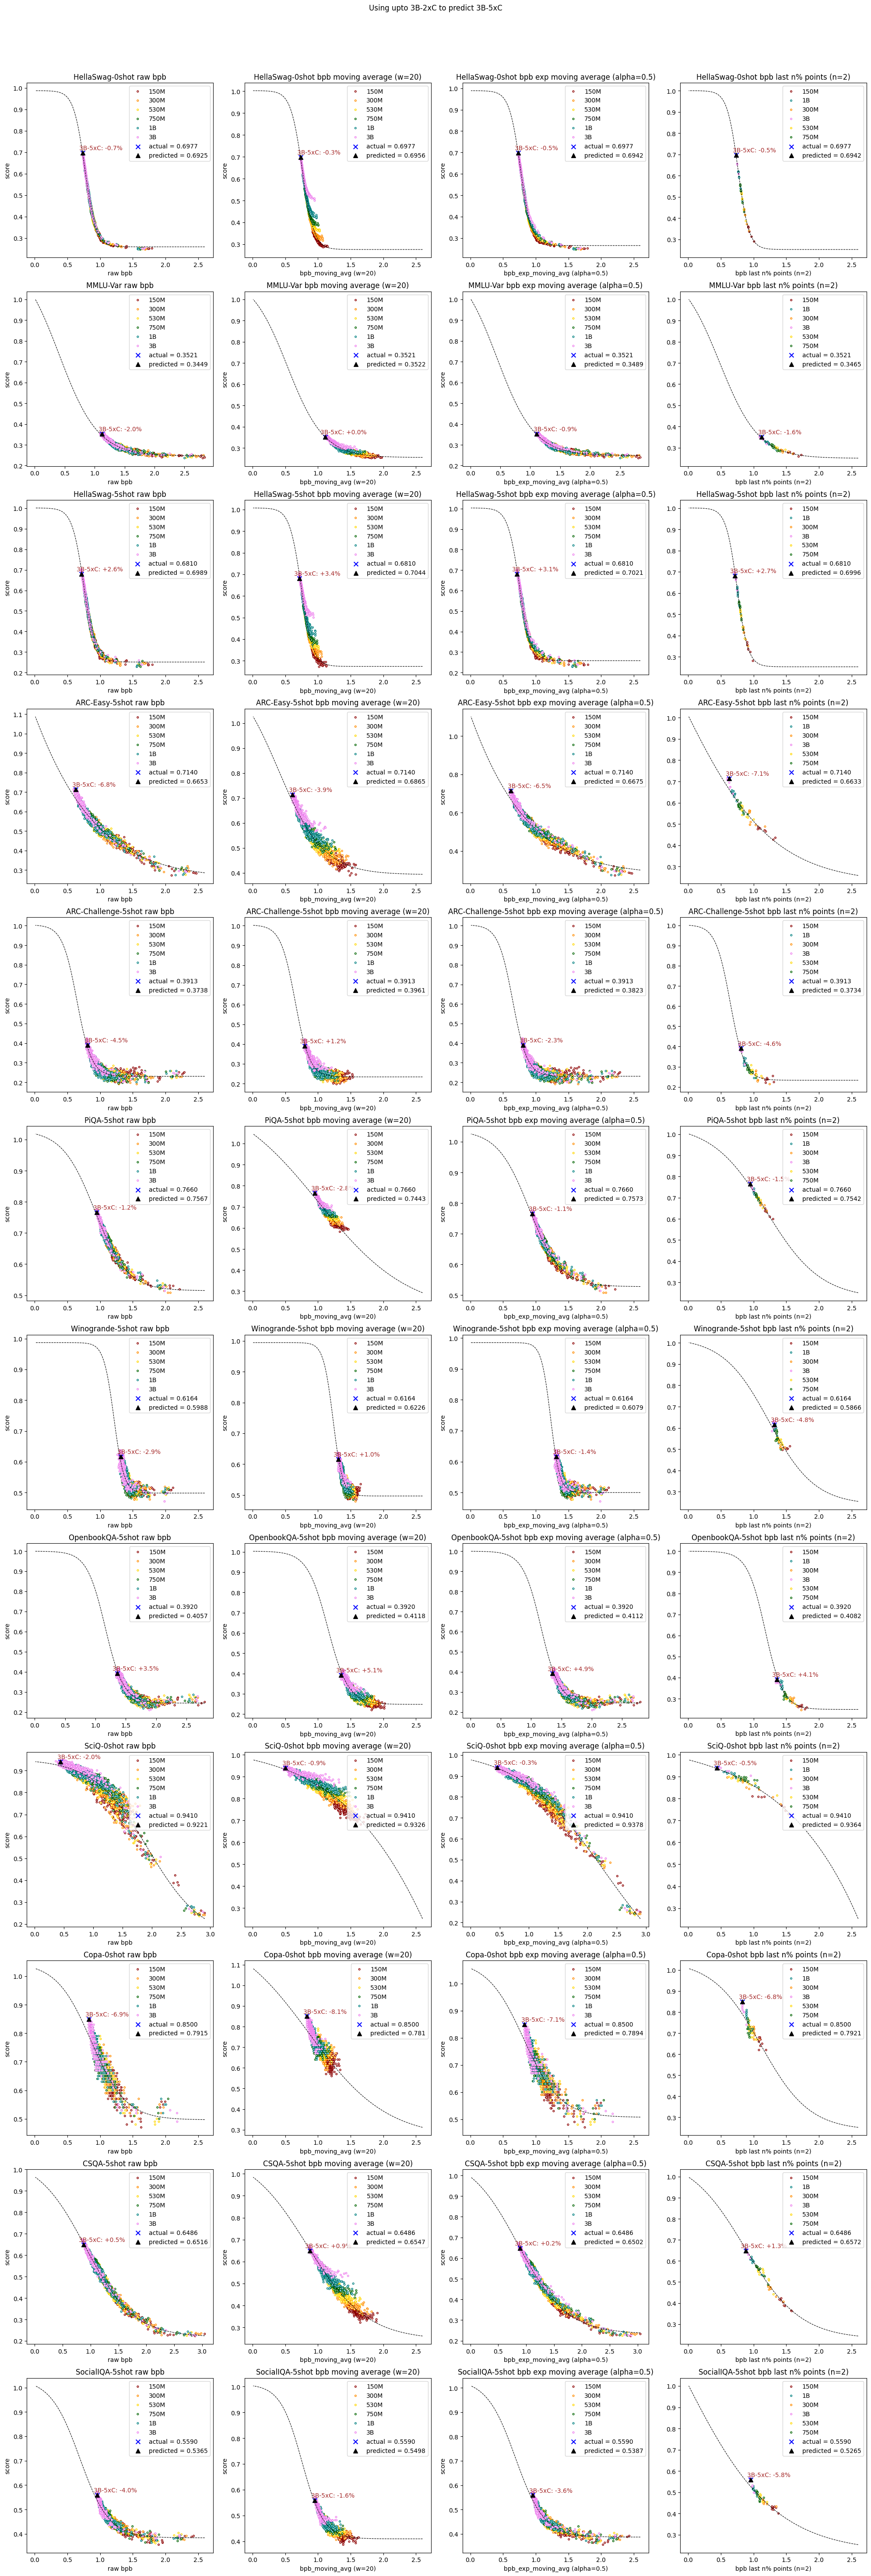

In [14]:
rows = len(tasks.keys())
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))

rel_error_raw = {}
rel_error_moving_average = {}
rel_error_exp_moving_average = {}
rel_error_last_n_perc = {}

def get_predicted_error(df):
    eval_row = df[df["mode"]=="eval"].iloc[-1]
    x = eval_row["x"]
    y = eval_row["y"]
    y_pred = eval_row["predicted_y"]
    rel_error = (y_pred - y) / y
    #rel_error = f"{rel_error * 100:+.1f}%"
    return rel_error

for i, (task_name, task) in enumerate(tasks.items()):
    
    bpb_loss = get_all_data_by_name(configs, task['bpb'])
    downstream_loss = get_all_data_by_name(configs, task['score'])
    
    df = get_dataframe(bpb_loss, downstream_loss)
    df = fit_and_plot(
        df,
        axes[i][0],
        # task.get("x_label", task['bpb']),
        # task.get("y_label", task['score']),
        x_label="raw bpb",
        y_label="score",
        title=f"{task_name} raw bpb"
    )
    rel_error_raw[task_name] = get_predicted_error(df)
    
    df = get_dataframe(bpb_loss, downstream_loss)
    df["x"] = df.groupby('run')['x'].transform(lambda x: x.rolling(window=20).mean())
    #df["x"] = df.groupby('run')['x'].transform(lambda x: x.where(df['mode'] != "train", other=x.rolling(window=20).mean()))
    df = fit_and_plot(
        df,
        axes[i][1],
        # x_label=str(task.get("x_label", task['bpb'])) + "_moving_avg",
        # y_label=str(task.get("y_label", task['score'])) + "_moving_avg",
        x_label="bpb_moving_avg (w=20)",
        y_label="score",
        title=f"{task_name} bpb moving average (w=20)"
    )
    rel_error_moving_average[task_name] = get_predicted_error(df)

    df = get_dataframe(bpb_loss, downstream_loss)
    df["x"] = df.groupby('run')['x'].transform(lambda x: x.ewm(alpha=0.5).mean())
    #df["x"] = df.groupby('run')['x'].transform(lambda x: x.where(df['mode'] != "train", other=x.ewm(alpha=0.5).mean()))
    df = fit_and_plot(
        df,
        axes[i][2],
        x_label="bpb_exp_moving_avg (alpha=0.5)",
        y_label="score",
        # x_label=str(task.get("x_label", task['bpb'])) + "_exp_moving_avg",
        # y_label=str(task.get("y_label", task['score'])) + "_exp_moving_avg",
        title=f"{task_name} bpb exp moving average (alpha=0.5)"
    )
    rel_error_exp_moving_average[task_name] = get_predicted_error(df)

    df = get_dataframe(bpb_loss, downstream_loss)
    df = df.groupby('run').apply(lambda x: x.iloc[-int(np.ceil(0.02*len(x))):], include_groups=False).reset_index()
    df = fit_and_plot(
        df,
        axes[i][3],
        x_label="bpb last n% points (n=2)",
        # x_label=str(task.get("x_label", task['bpb'])) + "_last_n%",
        # y_label=str(task.get("y_label", task['score'])) + "_last_n%",
        title=f"{task_name} bpb last n% points (n=2)"
    )
    rel_error_last_n_perc[task_name] = get_predicted_error(df)

fig.suptitle('Using upto 3B-2xC to predict 3B-5xC', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
#plt.savefig(f"{FIGURES}/downstream-upto-1B-5xC.png", dpi=300)

In [15]:
def prettify(rel_error):
    return f"{rel_error * 100:+.1f}%"

mkdn = """| Task | rel error (raw) | rel error (w = 20) | rel error (alpha = 0.5) | rel error (last 2%) |\n| --- | --- | --- | --- | --- |"""
for task in tasks:
    mkdn += f"\n| {task} | {prettify(rel_error_raw[task])} | {prettify(rel_error_moving_average[task])} | {prettify(rel_error_exp_moving_average[task])} | {prettify(rel_error_last_n_perc[task])} |"

mkdn += f"\n| **Average error** | **{prettify(np.mean(list(rel_error_raw.values())))}** | **{prettify(np.mean(list(rel_error_moving_average.values())))}** | **{prettify(np.mean(list(rel_error_exp_moving_average.values())))}** | **{prettify(np.mean(list(rel_error_last_n_perc.values())))}**|"
print(mkdn)

| Task | rel error (raw) | rel error (w = 20) | rel error (alpha = 0.5) | rel error (last 2%) |
| --- | --- | --- | --- | --- |
| HellaSwag-0shot | -0.7% | -0.3% | -0.5% | -0.5% |
| MMLU-Var | -2.0% | +0.0% | -0.9% | -1.6% |
| HellaSwag-5shot | +2.6% | +3.4% | +3.1% | +2.7% |
| ARC-Easy-5shot | -6.8% | -3.9% | -6.5% | -7.1% |
| ARC-Challenge-5shot | -4.5% | +1.2% | -2.3% | -4.6% |
| PiQA-5shot | -1.2% | -2.8% | -1.1% | -1.5% |
| Winogrande-5shot | -2.9% | +1.0% | -1.4% | -4.8% |
| OpenbookQA-5shot | +3.5% | +5.1% | +4.9% | +4.1% |
| SciQ-0shot | -2.0% | -0.9% | -0.3% | -0.5% |
| Copa-0shot | -6.9% | -8.1% | -7.1% | -6.8% |
| CSQA-5shot | +0.5% | +0.9% | +0.2% | +1.3% |
| SocialIQA-5shot | -4.0% | -1.6% | -3.6% | -5.8% |
| **Average error** | **-2.0%** | **-0.5%** | **-1.3%** | **-2.1%**|


### Using upto 1B-10xC to predict 1B-3T

**Note: For this particular 1B-3T run, we only have the metrics for the final checkpoint, so cannot do moving average window predictions.**

In [16]:
configs = {
    "150m": {
        "paths": [
            "wandb/amberish-rulebased/150M-1xC.csv",
            "wandb/amberish-rulebased/150M-2xC.csv",
            "wandb/amberish-rulebased/150M-5xC.csv",
            "wandb/amberish-rulebased/150M-10xC.csv"
        ],
        "mode": "train",
        "n": 151898880,
        "label": "150m",
        "color": "darkred"
    },
    "300m": {
        "paths": [
            "wandb/amberish-rulebased/300M-1xC.csv",
            "wandb/amberish-rulebased/300M-2xC.csv",
            "wandb/amberish-rulebased/300M-5xC.csv",
            "wandb/amberish-rulebased/300M-10xC.csv"
        ],
        "mode": "train",
        "n": 319980544,
        "label": "300m",
        "color": "darkorange"
    },
    "530m": {
        "paths": [
            "wandb/amberish-rulebased/530M-1xC.csv",
            "wandb/amberish-rulebased/530M-2xC.csv",
            "wandb/amberish-rulebased/530M-5xC.csv",
            "wandb/amberish-rulebased/530M-10xC.csv"
        ],
        "mode": "train",
        "n": 530074944,
        "label": "530m",
        "color": "gold"
    },
    "700m": {
        "paths": [
            "wandb/amberish-rulebased/750M-1xC.csv",
            "wandb/amberish-rulebased/750M-2xC.csv",
            "wandb/amberish-rulebased/750M-5xC.csv",
            "wandb/amberish-rulebased/750M-10xC.csv"
        ],
        "mode": "train",
        "n": 681297408,
        "label": "750m",
        "color": "darkgreen"
    },
    "1b": {
        "paths": [
            "wandb/amberish-rulebased/1B-1xC.csv",
            "wandb/amberish-rulebased/1B-2xC.csv",
            "wandb/amberish-rulebased/1B-5xC.csv",
            "wandb/amberish-rulebased/1B-10xC.csv"
        ],
        "mode": "train",
        "n": 1176832000,
        "label": "1b",
        "color": "teal"
    },
    "1b-final": {
        "paths": [
            "wandb/amberish1-newline/1B-3T-renamed.csv"
        ],
        "mode": "eval",
        "n": 1176832000,
        "label": "1b",
        "color": "teal"
    }
}

configs = {name: FinalConfig(**config) for name, config in configs.items()}

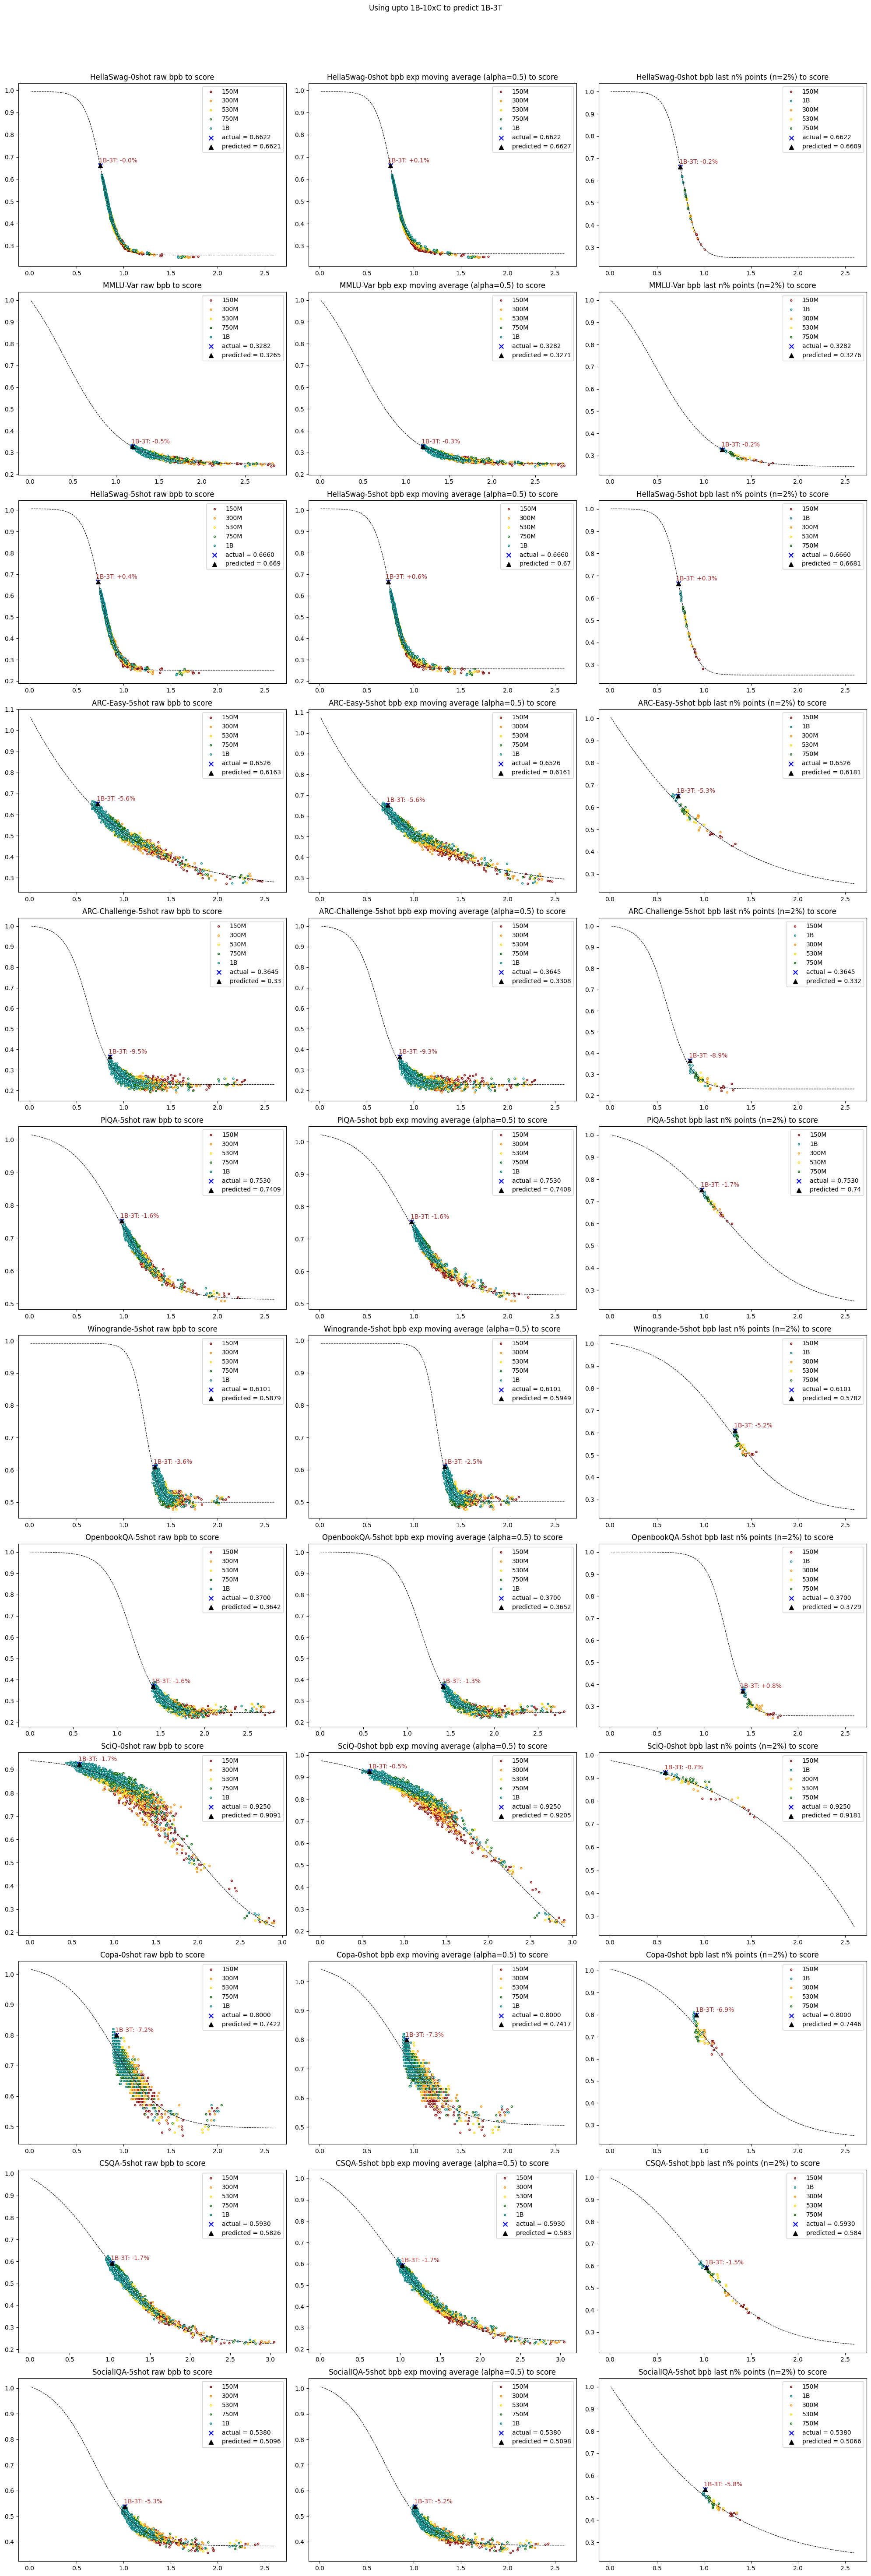

In [17]:
rows = len(tasks.keys())
fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))

rel_error_raw = {}
rel_error_moving_average = {}
rel_error_exp_moving_average = {}
rel_error_last_n_perc = {}

def get_predicted_error(df):
    eval_row = df[df["mode"]=="eval"].iloc[-1]
    x = eval_row["x"]
    y = eval_row["y"]
    y_pred = eval_row["predicted_y"]
    rel_error = (y_pred - y) / y
    #rel_error = f"{rel_error * 100:+.1f}%"
    return rel_error

for i, (task_name, task) in enumerate(tasks.items()):
    
    bpb_loss = get_all_data_by_name(configs, task['bpb'])
    downstream_loss = get_all_data_by_name(configs, task['score'])
    
    df = get_dataframe(bpb_loss, downstream_loss)
    df = fit_and_plot(
        df,
        axes[i][0],
        # task.get("x_label", task['bpb']),
        # task.get("y_label", task['score']),
        title=f"{task_name} raw bpb to score"
    )
    rel_error_raw[task_name] = get_predicted_error(df)

    df = get_dataframe(bpb_loss, downstream_loss)
    df["x"] = df.groupby('run')['x'].transform(lambda x: x.ewm(alpha=0.5).mean())
    df = fit_and_plot(
        df,
        axes[i][1],
        # x_label=str(task.get("x_label", task['bpb'])) + "_exp_moving_avg",
        # y_label=str(task.get("y_label", task['score'])) + "_exp_moving_avg",
        title=f"{task_name} bpb exp moving average (alpha=0.5) to score"
    )
    rel_error_exp_moving_average[task_name] = get_predicted_error(df)

    df = get_dataframe(bpb_loss, downstream_loss)
    df = df.groupby('run').apply(lambda x: x.iloc[-int(np.ceil(0.02*len(x))):], include_groups=False).reset_index()
    df = fit_and_plot(
        df,
        axes[i][2],
        # x_label=str(task.get("x_label", task['bpb'])) + "_last_n%",
        # y_label=str(task.get("y_label", task['score'])) + "_last_n%",
        title=f"{task_name} bpb last n% points (n=2%) to score"
    )
    rel_error_last_n_perc[task_name] = get_predicted_error(df)

fig.suptitle('Using upto 1B-10xC to predict 1B-3T', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
#plt.savefig(f"{FIGURES}/downstream-upto-1B-5xC.png", dpi=300)

In [18]:
def prettify(rel_error):
    return f"{rel_error * 100:+.1f}%"

mkdn = """| Task | rel error (raw) | rel error (w = 20) | rel error (alpha = 0.5) | rel error (last 2%) |\n| --- | --- | --- | --- | --- |"""
for task in tasks:
    mkdn += f"\n| {task} | {prettify(rel_error_raw[task])} | NA | {prettify(rel_error_exp_moving_average[task])} | {prettify(rel_error_last_n_perc[task])} |"

mkdn += f"\n| **Average error** | **{prettify(np.mean(list(rel_error_raw.values())))}** | **NA** | **{prettify(np.mean(list(rel_error_exp_moving_average.values())))}** | **{prettify(np.mean(list(rel_error_last_n_perc.values())))}**|"
print(mkdn)

| Task | rel error (raw) | rel error (w = 20) | rel error (alpha = 0.5) | rel error (last 2%) |
| --- | --- | --- | --- | --- |
| HellaSwag-0shot | -0.0% | NA | +0.1% | -0.2% |
| MMLU-Var | -0.5% | NA | -0.3% | -0.2% |
| HellaSwag-5shot | +0.4% | NA | +0.6% | +0.3% |
| ARC-Easy-5shot | -5.6% | NA | -5.6% | -5.3% |
| ARC-Challenge-5shot | -9.5% | NA | -9.3% | -8.9% |
| PiQA-5shot | -1.6% | NA | -1.6% | -1.7% |
| Winogrande-5shot | -3.6% | NA | -2.5% | -5.2% |
| OpenbookQA-5shot | -1.6% | NA | -1.3% | +0.8% |
| SciQ-0shot | -1.7% | NA | -0.5% | -0.7% |
| Copa-0shot | -7.2% | NA | -7.3% | -6.9% |
| CSQA-5shot | -1.7% | NA | -1.7% | -1.5% |
| SocialIQA-5shot | -5.3% | NA | -5.2% | -5.8% |
| **Average error** | **-3.2%** | **NA** | **-2.9%** | **-3.0%**|


## Using {150M, 300M, 530M, 750M, 1B} x {1xC, 2xC, 5xC, 10xC} to predict 3B-5xC 

This is the harder setting, where we do not use 3B runs trained upto 2xC. This is to mimic the situation where we want to predict, say 7B or 70B task scores, and do not have the budget to do multiple runs upto 2xC for the large model.

In [19]:
configs = {
    "150m": {
        "paths": [
            "wandb/amberish-rulebased/150M-1xC.csv",
            "wandb/amberish-rulebased/150M-2xC.csv",
            "wandb/amberish-rulebased/150M-5xC.csv",
            "wandb/amberish-rulebased/150M-10xC.csv"
        ],
        "mode": "train",
        "n": 151898880,
        "label": "150m",
        "color": "darkred"
    },
    "300m": {
        "paths": [
            "wandb/amberish-rulebased/300M-1xC.csv",
            "wandb/amberish-rulebased/300M-2xC.csv",
            "wandb/amberish-rulebased/300M-5xC.csv",
            "wandb/amberish-rulebased/300M-10xC.csv"
        ],
        "mode": "train",
        "n": 319980544,
        "label": "300m",
        "color": "darkorange"
    },
    "530m": {
        "paths": [
            "wandb/amberish-rulebased/530M-1xC.csv",
            "wandb/amberish-rulebased/530M-2xC.csv",
            "wandb/amberish-rulebased/530M-5xC.csv",
            "wandb/amberish-rulebased/530M-10xC.csv"
        ],
        "mode": "train",
        "n": 530074944,
        "label": "530m",
        "color": "gold"
    },
    "700m": {
        "paths": [
            "wandb/amberish-rulebased/750M-1xC.csv",
            "wandb/amberish-rulebased/750M-2xC.csv",
            "wandb/amberish-rulebased/750M-5xC.csv",
            "wandb/amberish-rulebased/750M-10xC.csv"
        ],
        "mode": "train",
        "n": 681297408,
        "label": "750m",
        "color": "darkgreen"
    },
    "1b": {
        "paths": [
            "wandb/amberish-rulebased/1B-1xC.csv",
            "wandb/amberish-rulebased/1B-2xC.csv",
            "wandb/amberish-rulebased/1B-5xC.csv",
            "wandb/amberish-rulebased/1B-10xC.csv"
        ],
        "mode": "train",
        "n": 1176832000,
        "label": "1b",
        "color": "teal"
    },
    "3b-final": {
        "paths": [
            "wandb/amberish-rulebased/3B-5xC.csv"
            #"wandb/amberish1-newline/1B-3T.csv"
        ],
        "mode": "eval",
        "n": 3002871040,
        "label": "3b",
        "color": "violet"
    }
}

configs = {name: FinalConfig(**config) for name, config in configs.items()}

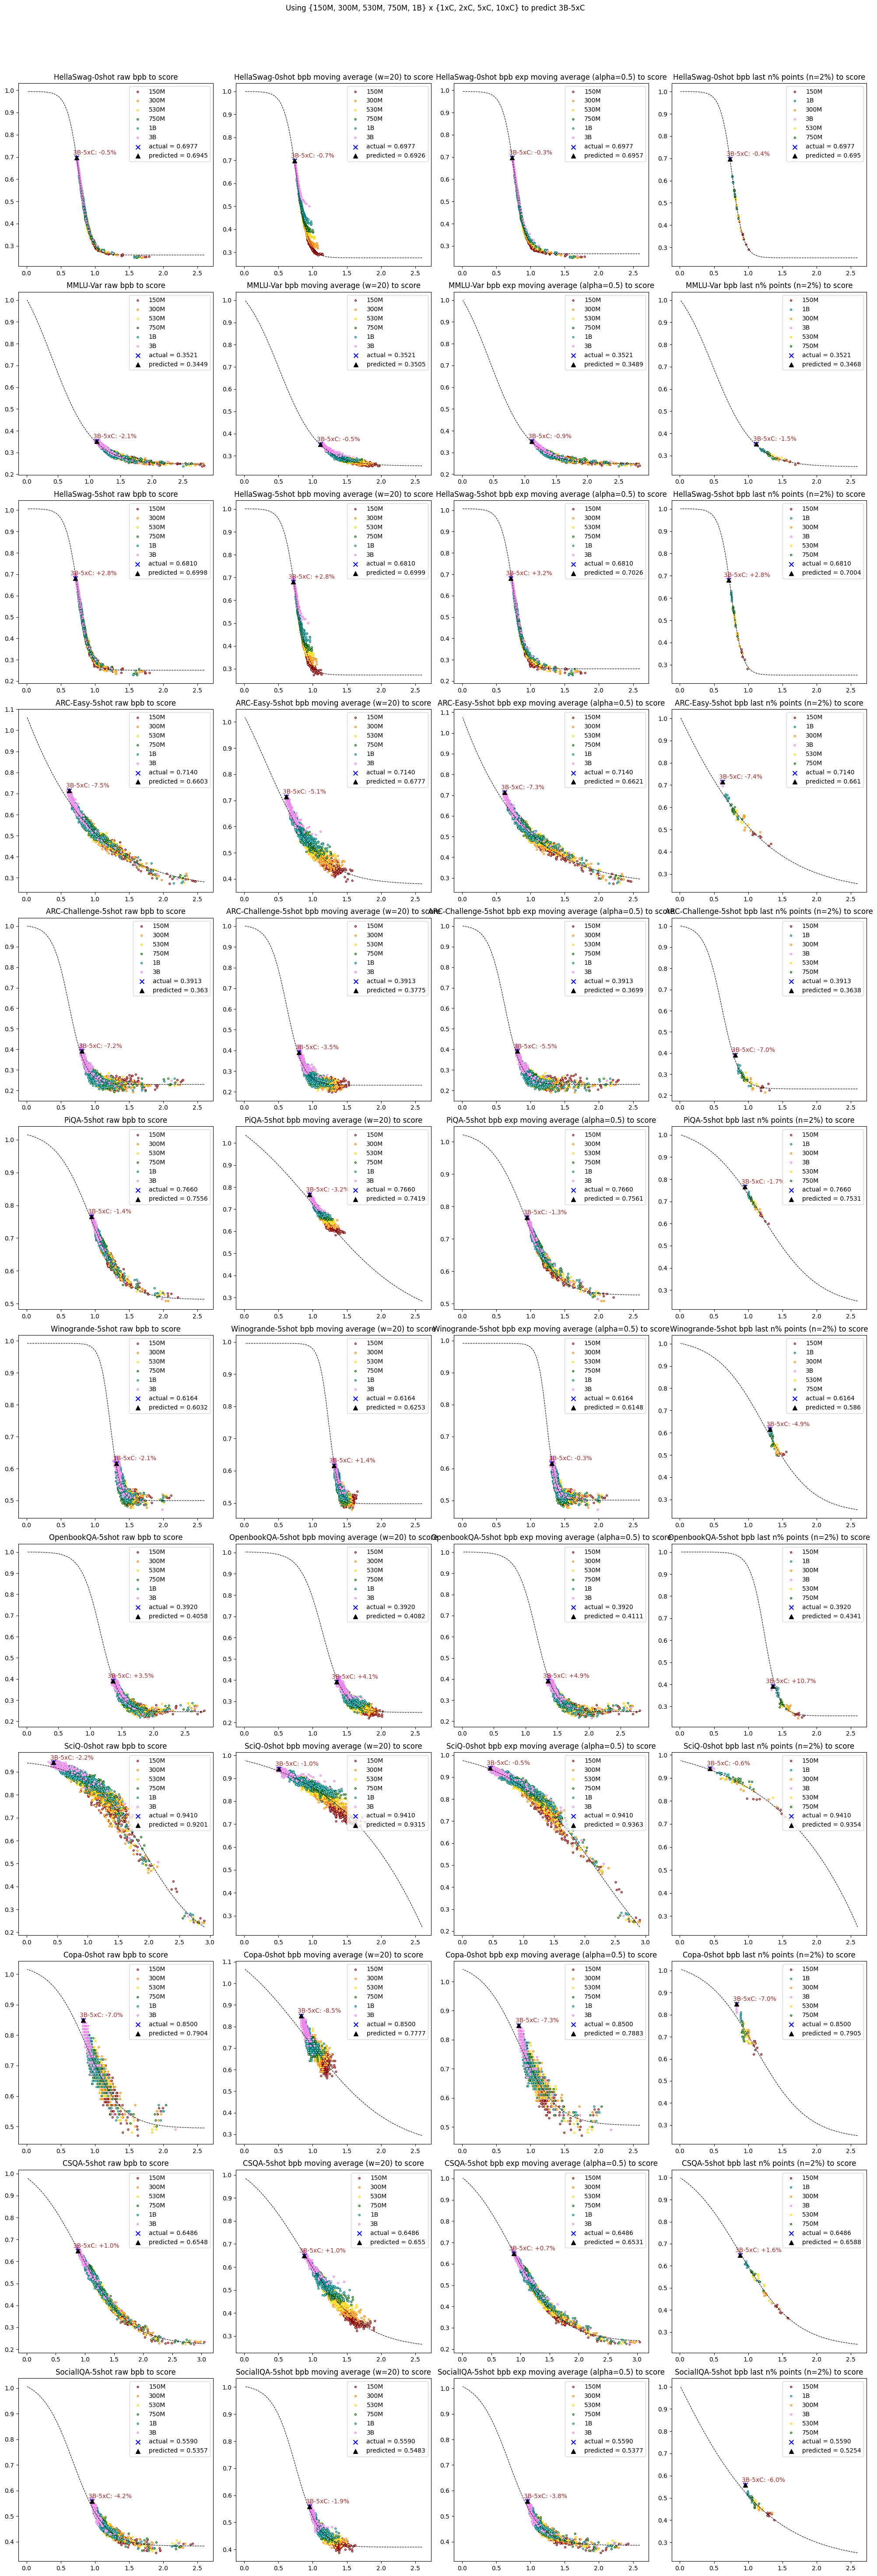

In [20]:
rows = len(tasks.keys())
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))

rel_error_raw = {}
rel_error_moving_average = {}
rel_error_exp_moving_average = {}
rel_error_last_n_perc = {}

def get_predicted_error(df):
    eval_row = df[df["mode"]=="eval"].iloc[-1]
    x = eval_row["x"]
    y = eval_row["y"]
    y_pred = eval_row["predicted_y"]
    rel_error = (y_pred - y) / y
    #rel_error = f"{rel_error * 100:+.1f}%"
    return rel_error

for i, (task_name, task) in enumerate(tasks.items()):
    
    bpb_loss = get_all_data_by_name(configs, task['bpb'])
    downstream_loss = get_all_data_by_name(configs, task['score'])
    
    df = get_dataframe(bpb_loss, downstream_loss)
    df = fit_and_plot(
        df,
        axes[i][0],
        # task.get("x_label", task['bpb']),
        # task.get("y_label", task['score']),
        title=f"{task_name} raw bpb to score"
    )
    rel_error_raw[task_name] = get_predicted_error(df)
    
    df = get_dataframe(bpb_loss, downstream_loss)
    df["x"] = df.groupby('run')['x'].transform(lambda x: x.rolling(window=20).mean())
    df = fit_and_plot(
        df,
        axes[i][1],
        # x_label=str(task.get("x_label", task['bpb'])) + "_moving_avg",
        # y_label=str(task.get("y_label", task['score'])) + "_moving_avg",
        title=f"{task_name} bpb moving average (w=20) to score"
    )
    rel_error_moving_average[task_name] = get_predicted_error(df)

    df = get_dataframe(bpb_loss, downstream_loss)
    df["x"] = df.groupby('run')['x'].transform(lambda x: x.ewm(alpha=0.5).mean())
    df = fit_and_plot(
        df,
        axes[i][2],
        # x_label=str(task.get("x_label", task['bpb'])) + "_exp_moving_avg",
        # y_label=str(task.get("y_label", task['score'])) + "_exp_moving_avg",
        title=f"{task_name} bpb exp moving average (alpha=0.5) to score"
    )
    rel_error_exp_moving_average[task_name] = get_predicted_error(df)

    df = get_dataframe(bpb_loss, downstream_loss)
    df = df.groupby('run').apply(lambda x: x.iloc[-int(np.ceil(0.02*len(x))):], include_groups=False).reset_index()
    df = fit_and_plot(
        df,
        axes[i][3],
        # x_label=str(task.get("x_label", task['bpb'])) + "_last_n%",
        # y_label=str(task.get("y_label", task['score'])) + "_last_n%",
        title=f"{task_name} bpb last n% points (n=2%) to score"
    )
    rel_error_last_n_perc[task_name] = get_predicted_error(df)

fig.suptitle('Using {150M, 300M, 530M, 750M, 1B} x {1xC, 2xC, 5xC, 10xC} to predict 3B-5xC', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
#plt.savefig(f"{FIGURES}/downstream-upto-750M-10xC.png", dpi=300)

In [21]:
def prettify(rel_error):
    return f"{rel_error * 100:+.1f}%"

mkdn = """| Task | rel error (raw) | rel error (w = 20) | rel error (alpha = 0.5) | rel error (last 2%) |\n| --- | --- | --- | --- | --- |"""
for task in tasks:
    mkdn += f"\n| {task} | {prettify(rel_error_raw[task])} | {prettify(rel_error_moving_average[task])} | {prettify(rel_error_exp_moving_average[task])} | {prettify(rel_error_last_n_perc[task])} |"

mkdn += f"\n| **Average error** | **{prettify(np.mean(list(rel_error_raw.values())))}** | **{prettify(np.mean(list(rel_error_moving_average.values())))}** | **{prettify(np.mean(list(rel_error_exp_moving_average.values())))}** | **{prettify(np.mean(list(rel_error_last_n_perc.values())))}**|"
print(mkdn)

| Task | rel error (raw) | rel error (w = 20) | rel error (alpha = 0.5) | rel error (last 2%) |
| --- | --- | --- | --- | --- |
| HellaSwag-0shot | -0.5% | -0.7% | -0.3% | -0.4% |
| MMLU-Var | -2.1% | -0.5% | -0.9% | -1.5% |
| HellaSwag-5shot | +2.8% | +2.8% | +3.2% | +2.8% |
| ARC-Easy-5shot | -7.5% | -5.1% | -7.3% | -7.4% |
| ARC-Challenge-5shot | -7.2% | -3.5% | -5.5% | -7.0% |
| PiQA-5shot | -1.4% | -3.2% | -1.3% | -1.7% |
| Winogrande-5shot | -2.1% | +1.4% | -0.3% | -4.9% |
| OpenbookQA-5shot | +3.5% | +4.1% | +4.9% | +10.7% |
| SciQ-0shot | -2.2% | -1.0% | -0.5% | -0.6% |
| Copa-0shot | -7.0% | -8.5% | -7.3% | -7.0% |
| CSQA-5shot | +1.0% | +1.0% | +0.7% | +1.6% |
| SocialIQA-5shot | -4.2% | -1.9% | -3.8% | -6.0% |
| **Average error** | **-2.2%** | **-1.3%** | **-1.5%** | **-1.8%**|
